In [1]:
import cv2
from moviepy import VideoFileClip
import time
import base64

VIDEO_PATH = "video.mp4"

In [2]:
import os

In [3]:
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=5)
print("Done")
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)


MoviePy - Writing audio in video.mp3


MoviePy - Done.
Extracted 35 frames
Extracted audio to video.mp3
Done
MoviePy - Writing audio in video.mp3


MoviePy - Done.
Extracted 179 frames
Extracted audio to video.mp3


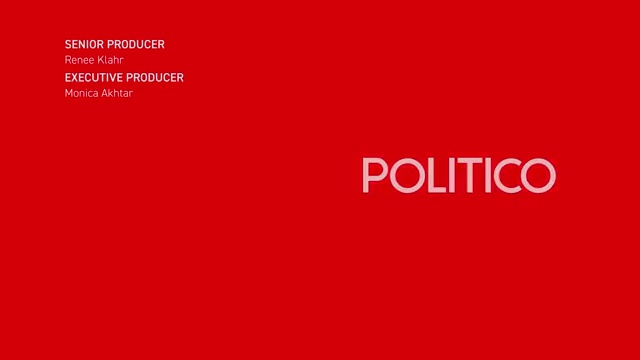

In [4]:
from IPython.display import display, Image
import base64

# Simulating the display update process
display_handle = display(None, display_id=True)
for img in base64Frames:
    decoded_image = base64.b64decode(img.encode("utf-8"))
    display_handle.update(Image(data=decoded_image))  # Ensure Image is properly imported
    time.sleep(0.025)


In [5]:
from openai import OpenAI, ChatCompletion
import dotenv
dotenv.load_dotenv()
client = OpenAI()


In [14]:
response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

# Video Summary

The video features a political rally led by Donald Trump, where he discusses his campaign for the 2024 presidential election. The event is characterized by a backdrop of American flags and a prominent campaign sign reading "Trump Vance 2024." 

## Key Highlights:
- **Trump's Speech**: Throughout the video, Trump addresses the audience, emphasizing his campaign message and engaging with supporters. His gestures and expressions convey enthusiasm and confidence.
- **Supporters**: The crowd appears energized, showing support for Trump as he speaks. Various frames capture the audience's reactions, including applause and cheers.
- **Guest Appearances**: Dana White, the CEO of the Ultimate Fighting Championship, also makes an appearance, speaking alongside Trump and further rallying the crowd.
- **Campaign Themes**: The speech touches on themes of making America great again, with Trump reiterating his commitment to fixing issues he identifies in the current political landscap

In [7]:
# Transcribe the audio
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb"),
)
## OPTIONAL: Uncomment the line below to print the transcription
# print("Transcript: ", transcription.text + "\n\n")

# response = client.chat.completions.create(
#     model='gpt-4o-mini',
#     messages=[
#     {"role": "system", "content":"""You are generating a transcript summary. Create a summary of the provided transcription. Respond in Markdown."""},
#     {"role": "user", "content": [
#         {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
#         ],
#     }
#     ],
#     temperature=0,
# )
# print(response.choices[0].message.content)

In [8]:
## Generate a summary with visual and audio
response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

# Video Summary

The video features a speech by Donald Trump, where he reflects on his political journey and expresses gratitude to the American people for their support. He emphasizes the significance of his election as both the 45th and 47th president, declaring it a remarkable political comeback. Trump outlines his vision for a prosperous America, focusing on strong borders and legal immigration. He mentions various public figures, including Elon Musk and Joe Rogan, and highlights the importance of protecting American talent.

Key points from the speech include:

- **Political Comeback**: Trump claims to have witnessed the greatest political comeback in U.S. history.
- **Economic Vision**: He promises to lead the country towards a significant economic recovery.
- **Unity and Progress**: Trump calls for unity among Americans, urging them to put past divisions behind.
- **Future Aspirations**: He envisions a future for America that is bigger, better, and stronger.

The speech conclude

In [10]:
a = {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }

In [13]:
len(a)

2